# Neural networl structure

In [1]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.display import Image
from sklearn.model_selection import train_test_split


# Define the model
class Seq2SeqModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        output = self.fc(output)
        return output


# Defining Loss function

In [41]:

class CustomLoss(nn.Module):
    def __init__(self, conflict_matrix):
        super(CustomLoss, self).__init__()
        self.conflict_matrix = conflict_matrix

    def has_conflict(self, last_input_num, first_output_num):
        """
        Check if there's a conflict between the last number of the input sequence and the first number of the output sequence.
        Args:
        - last_input_num (int): The last number of the input sequence.
        - first_output_num (int): The first number of the output sequence.
        Returns:
        - bool: True if there's a conflict, False otherwise.
        """
        return self.conflict_matrix[last_input_num - 1, first_output_num - 1] == 1

    def is_valid_permutation(self, output_seq):
        """
        Check if the output sequence is a valid permutation of a group of 5 numbers.
        Args:
        - output_seq (list): The output sequence.
        Returns:
        - bool: True if the output sequence is a valid permutation, False otherwise.
        """
        group_size = 5
        for i in range(0, len(output_seq), group_size):
            if sorted(output_seq[i:i + group_size]) != list(range(i + 1, i + group_size + 1)):
                return False
        return True

    def permutation_penalty(self, output_seq):
        """
        Calculate the penalty for an invalid permutation.
        Args:
        - output_seq (list): The output sequence.
        Returns:
        - float: Penalty based on how far the sequence is from a valid permutation.
        """
        group_size = 5
        penalty = 0.0
        for i in range(0, len(output_seq), group_size):
            expected_group = set(range(i + 1, i + group_size + 1))
            actual_group = set(output_seq[i:i + group_size])
            penalty += len(expected_group - actual_group)
        return penalty

    def forward(self, outputs, targets, inputs):
        """
        Calculate the custom loss for a batch of sequences.
        Args:
        - outputs (Tensor): The model's predicted outputs.
        - targets (Tensor): The true target sequences.
        - inputs (Tensor): The input sequences.
        Returns:
        - Tensor: The average loss for the batch.
        """
        batch_size = outputs.size(0)
        total_loss = 0
        valid_loss_count = 0

        for i in range(batch_size):
            last_input_num = inputs[i, -1].item()  # Get the last number of the input sequence
            first_output_num = torch.argmax(outputs[i][0]).item()  # Get the first number of the predicted output sequence

            # Conflict loss
            if self.has_conflict(last_input_num, first_output_num):
                loss = F.cross_entropy(outputs[i].view(-1, outputs.size(-1)), targets[i].view(-1))
                total_loss += loss
                valid_loss_count += 1
                #print(f"Conflict detected: {last_input_num} -> {first_output_num}, Loss: {loss.item()}")

            # Duplicate penalty
            output_seq = torch.argmax(outputs[i], dim=1).tolist()
            duplicate_count = len(output_seq) - len(set(output_seq))
            if duplicate_count > 0:
                duplicate_penalty = torch.tensor(duplicate_count, dtype=torch.float, requires_grad=True)
                total_loss += duplicate_penalty
                valid_loss_count += 1
                #print(f"Duplicate detected in sequence: {output_seq}, Penalty: {duplicate_penalty.item()}")

            # Missing number penalty
            if not self.is_valid_permutation(output_seq):
                missing_penalty = torch.tensor(self.permutation_penalty(output_seq), dtype=torch.float, requires_grad=True)
                total_loss += missing_penalty
                valid_loss_count += 1
                #print(f"Invalid permutation detected in sequence: {output_seq}, Penalty: {missing_penalty.item()}")

        if valid_loss_count > 0:
            total_loss = total_loss / valid_loss_count  # Average over valid losses
        else:
            total_loss = torch.tensor(0.0, requires_grad=True)  # Return zero loss as a tensor if no valid loss

        #print(f"Total Loss for batch: {total_loss.item()}")
        return total_loss


# Preparing Data and Conflict matrix

In [32]:
# Prepare the data
num_people = 400
group_size = 5
max_conflicts = 600

all_numbers = list(range(1, num_people + 1))
groups = [all_numbers[i:i + group_size] for i in range(0, len(all_numbers), group_size)]

# Create a dictionary to map each person to their group
person_to_group = {}
for group_idx, group in enumerate(groups):
    for person in group:
        person_to_group[person] = group_idx

# Define the conflict matrix creation function
def create_conflict_matrix(num_people, num_conflicts, person_to_group):
    conflict_matrix = np.zeros((num_people, num_people), dtype=int)
    conflicts = []
    added_conflicts = 0
    while added_conflicts < num_conflicts:
        person1 = np.random.randint(1, num_people + 1)
        person2 = np.random.randint(1, num_people + 1)
        if person1 != person2 and person_to_group[person1] != person_to_group[person2]:
            if conflict_matrix[person1-1, person2-1] == 0:
                conflict_matrix[person1-1, person2-1] = 1
                conflict_matrix[person2-1, person1-1] = 1
                conflicts.append((person1, person2))
                added_conflicts += 1
    return conflict_matrix, conflicts

# Create conflict matrix and record conflicts
conflict_matrix, conflicts = create_conflict_matrix(num_people, max_conflicts, person_to_group)

# Generate all permutations
all_permutations_flat = [perm for group in groups for perm in itertools.permutations(group)]

# Count the number of 1s in the matrix
total_conflicts = np.sum(conflict_matrix)
unique_conflicts = total_conflicts // 2  # Each conflict is counted twice

# Print the total number of conflicts
print("Total number of 1s (conflicts) in the matrix:", total_conflicts)
print("Number of unique conflicts in the matrix:", unique_conflicts)

# Print the first 10 groups
print("First 10 groups:")
for i, group in enumerate(groups[:10]):
    print(f"Group {i+1}: {group}")

# Print the last 10 groups
print("Last 10 groups:")
for i, group in enumerate(groups[-10:], start=len(groups)-10):
    print(f"Group {i+1}: {group}")

# Print the first 10 conflicts
print("First 10 conflicts:")
for conflict in conflicts[:10]:
    person1, person2 = conflict
    print(f"Conflict between {person1} in group {person_to_group[person1]} and {person2} in group {person_to_group[person2]}")

# Print the last 10 conflicts
print("Last 10 conflicts:")
for conflict in conflicts[-10:]:
    person1, person2 = conflict
    print(f"Conflict between {person1} in group {person_to_group[person1]} and {person2} in group {person_to_group[person2]}")


Total number of 1s (conflicts) in the matrix: 1200
Number of unique conflicts in the matrix: 600
First 10 groups:
Group 1: [1, 2, 3, 4, 5]
Group 2: [6, 7, 8, 9, 10]
Group 3: [11, 12, 13, 14, 15]
Group 4: [16, 17, 18, 19, 20]
Group 5: [21, 22, 23, 24, 25]
Group 6: [26, 27, 28, 29, 30]
Group 7: [31, 32, 33, 34, 35]
Group 8: [36, 37, 38, 39, 40]
Group 9: [41, 42, 43, 44, 45]
Group 10: [46, 47, 48, 49, 50]
Last 10 groups:
Group 71: [351, 352, 353, 354, 355]
Group 72: [356, 357, 358, 359, 360]
Group 73: [361, 362, 363, 364, 365]
Group 74: [366, 367, 368, 369, 370]
Group 75: [371, 372, 373, 374, 375]
Group 76: [376, 377, 378, 379, 380]
Group 77: [381, 382, 383, 384, 385]
Group 78: [386, 387, 388, 389, 390]
Group 79: [391, 392, 393, 394, 395]
Group 80: [396, 397, 398, 399, 400]
First 10 conflicts:
Conflict between 333 in group 66 and 303 in group 60
Conflict between 250 in group 49 and 183 in group 36
Conflict between 167 in group 33 and 263 in group 52
Conflict between 121 in group 24 and 32

# Generating training data

In [4]:
# Initialize lists to store input (X) and output (Y) sequences
max_pairs = 100000
X = []
Y = []

print("Starting to generate input-output pairs...")
pair_count = 0

# Iterate through all permutations
for perm in all_permutations_flat:
    last_num = perm[-1]
    # Find valid output sequences that do not conflict with the last number of the current permutation
    valid_Ys = [other_perm for other_perm in all_permutations_flat if all(conflict_matrix[last_num-1, other_num-1] == 0 for other_num in other_perm)]
    if valid_Ys:
        # Randomly select up to 5 valid output sequences
        selected_indices = np.random.choice(len(valid_Ys), min(len(valid_Ys), 5), replace=False)
        for idx in selected_indices:
            X.append(perm)
            Y.append(valid_Ys[idx])
            pair_count += 1
            # Print progress every 1000 pairs
            if pair_count % 1000 == 0:
                print(f"Generated {pair_count} pairs so far...")
            # Stop if the maximum number of pairs is reached
            if pair_count >= max_pairs:
                break
    if pair_count >= max_pairs:
        break

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Print the shapes of the datasets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Print a small sample of the data to verify
print("Sample of input sequences (X):", X[:5])
print("Sample of output sequences (Y):", Y[:5])


Starting to generate input-output pairs...
Generated 1000 pairs so far...
Generated 2000 pairs so far...
Generated 3000 pairs so far...
Generated 4000 pairs so far...
Generated 5000 pairs so far...
Generated 6000 pairs so far...
Generated 7000 pairs so far...
Generated 8000 pairs so far...
Generated 9000 pairs so far...
Generated 10000 pairs so far...
Generated 11000 pairs so far...
Generated 12000 pairs so far...
Generated 13000 pairs so far...
Generated 14000 pairs so far...
Generated 15000 pairs so far...
Generated 16000 pairs so far...
Generated 17000 pairs so far...
Generated 18000 pairs so far...
Generated 19000 pairs so far...
Generated 20000 pairs so far...
Generated 21000 pairs so far...
Generated 22000 pairs so far...
Generated 23000 pairs so far...
Generated 24000 pairs so far...
Generated 25000 pairs so far...
Generated 26000 pairs so far...
Generated 27000 pairs so far...
Generated 28000 pairs so far...
Generated 29000 pairs so far...
Generated 30000 pairs so far...
Genera

In [5]:
# Print the shapes of the datasets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Print a small sample of the data to verify
print("Sample of input sequences (X):", X[:20])
print("Sample of output sequences (Y):", Y[:20])

# Print the last 20 samples of the data to verify
print("Last 20 samples of input sequences (X):", X[-20:])
print("Last 20 samples of output sequences (Y):", Y[-20:])

Shape of X: (48000, 5)
Shape of Y: (48000, 5)
Sample of input sequences (X): [[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 5 4]
 [1 2 3 5 4]
 [1 2 3 5 4]
 [1 2 3 5 4]
 [1 2 3 5 4]
 [1 2 4 3 5]
 [1 2 4 3 5]
 [1 2 4 3 5]
 [1 2 4 3 5]
 [1 2 4 3 5]
 [1 2 4 5 3]
 [1 2 4 5 3]
 [1 2 4 5 3]
 [1 2 4 5 3]
 [1 2 4 5 3]]
Sample of output sequences (Y): [[127 126 130 129 128]
 [268 266 270 267 269]
 [289 288 286 290 287]
 [144 142 143 145 141]
 [205 201 203 202 204]
 [389 390 387 386 388]
 [ 52  51  53  54  55]
 [111 113 115 114 112]
 [338 337 339 336 340]
 [248 249 250 247 246]
 [399 397 396 398 400]
 [206 207 210 208 209]
 [313 311 312 314 315]
 [102 103 101 105 104]
 [357 358 356 360 359]
 [218 220 217 219 216]
 [209 206 208 210 207]
 [227 230 229 226 228]
 [325 322 324 323 321]
 [396 400 397 398 399]]
Last 20 samples of input sequences (X): [[400 399 397 396 398]
 [400 399 397 396 398]
 [400 399 397 396 398]
 [400 399 397 396 398]
 [400 399 397 396 398]
 [400 399 397 

# Spliting to validation and training

In [6]:
# Split into training and validation sets
num_samples = len(X)  # Use the entire dataset (max_pairs)
val_size = int(num_samples * 0.1)
train_size = num_samples - val_size

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=train_size, test_size=val_size, random_state=42)

# Print the sizes of the training and validation sets
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Create DataLoaders
train_input_tensor = torch.tensor(X_train, dtype=torch.long)
train_output_tensor = torch.tensor(Y_train, dtype=torch.long)
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_input_tensor = torch.tensor(X_val, dtype=torch.long)
val_output_tensor = torch.tensor(Y_val, dtype=torch.long)
val_dataset = TensorDataset(val_input_tensor, val_output_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

# Print DataLoader sizes
print(f"Training DataLoader size: {len(train_loader.dataset)}, Validation DataLoader size: {len(val_loader.dataset)}")



Training samples: 43200, Validation samples: 4800
Training DataLoader size: 43200, Validation DataLoader size: 4800


# Initialize model, loss function, and optimizer

In [54]:
# Initialize model, loss function, and optimizer
input_dim = num_people + 1  #  input dimension
hidden_dim = 400  # Example hidden dimension
output_dim = num_people + 1  #  output dimension

model = Seq2SeqModel(input_dim, hidden_dim, output_dim)

custom_loss = CustomLoss(conflict_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

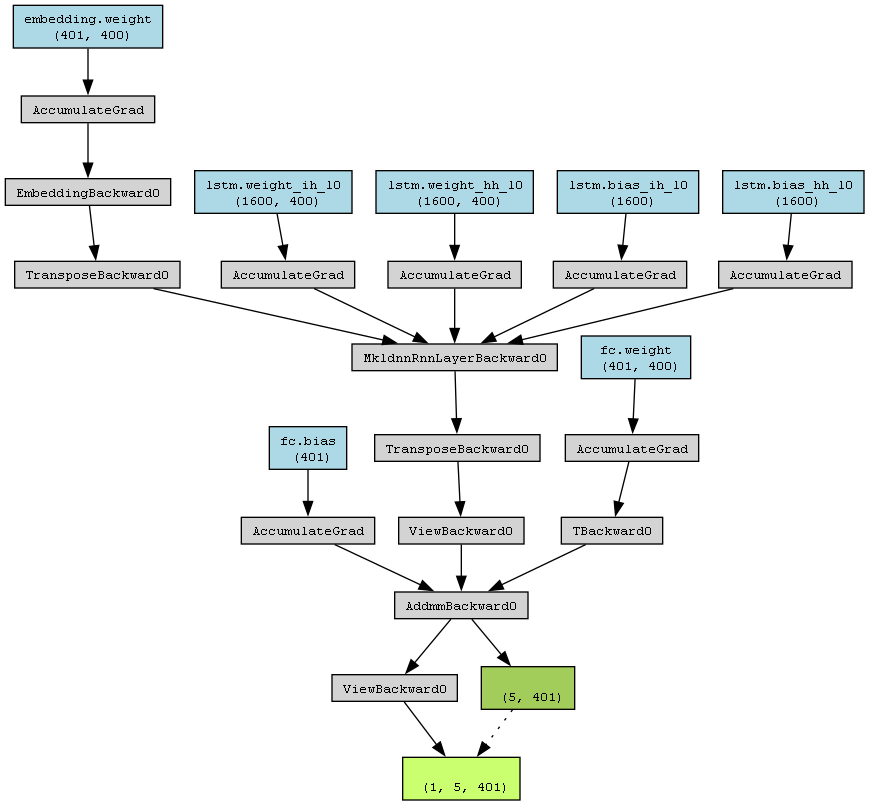

In [55]:
# Example input to visualize
example_input = torch.randint(0, input_dim, (1, 5), dtype=torch.long)  # Example batch of sequences
# Forward pass
outputs = model(example_input)
# Visualize the model
# Visualize the model
dot = make_dot(outputs, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('seq2seq_model')

# Display the image
Image(filename='seq2seq_model.png')

# Training the Neural Network

In [57]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss(outputs, targets, inputs)
        
        if isinstance(loss, torch.Tensor):  # Ensure that loss is a tensor
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        #if batch_idx % 100 == 0:
            #print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Calculate average epoch loss
    Training_Loss = epoch_loss / len(train_loader)
    
    # Print training loss for the epoch
    print(f"Epoch {epoch+1}, Training Loss: {Training_Loss}")
    
    # Early stopping condition
    if Training_Loss == 0:
        print(f"Early stopping at epoch {epoch+1}, with training loss {Training_Loss}")
        break

print("Training complete.")


Epoch 1, Training Loss: 4.005856666918154
Epoch 2, Training Loss: 3.9990727228588527
Epoch 3, Training Loss: 3.960951460202535
Epoch 4, Training Loss: 3.9394844731578122
Epoch 5, Training Loss: 3.9185489130020144
Epoch 6, Training Loss: 3.88838376239494
Epoch 7, Training Loss: 3.8586149111500494
Epoch 8, Training Loss: 3.853649101257324
Epoch 9, Training Loss: 3.8533763555244165
Epoch 10, Training Loss: 3.8528766245312163
Epoch 11, Training Loss: 3.8528071929790357
Epoch 12, Training Loss: 3.852240691361604
Epoch 13, Training Loss: 3.8527448523486103
Epoch 14, Training Loss: 3.8534511458432235
Epoch 15, Training Loss: 3.8530675428885
Epoch 16, Training Loss: 3.8524640275813917
Epoch 17, Training Loss: 3.8529917780558267
Epoch 18, Training Loss: 3.8531891499625313
Epoch 19, Training Loss: 3.852799107057077
Epoch 20, Training Loss: 3.853508093975208
Epoch 21, Training Loss: 3.8531867281595864
Epoch 22, Training Loss: 3.8531853905430546
Epoch 23, Training Loss: 3.8529679280740243
Epoch 24

In [58]:
# Validation loop
model.eval()
val_loss = 0
with torch.no_grad():
    for val_batch_idx, (val_inputs, val_targets) in enumerate(val_loader):
        val_outputs = model(val_inputs)
        val_batch_loss = custom_loss(val_outputs, val_targets, val_inputs)
        val_loss += val_batch_loss.item()

# Calculate average validation loss
Validation_Loss = val_loss / len(val_loader)

# Print validation loss
print(f"Validation Loss: {Validation_Loss}")

Validation Loss: 3.8344835503896078


# Generating output sequence and evaluate it

In [59]:
import torch
import numpy as np

def generate_full_sequence(model, start_seq, conflict_matrix, num_people=400, group_size=5):
    current_seq = start_seq
    all_used_numbers = set(current_seq)
    generated_sequences = [current_seq]

    while len(all_used_numbers) < num_people:
        input_tensor = torch.tensor(current_seq, dtype=torch.long).unsqueeze(0)
        output = model(input_tensor)
        predicted_seq = torch.argmax(output, dim=2).squeeze().tolist()

        # Ensure no conflicts and no repetitions, and the sequence has the correct group size
        if len(predicted_seq) == group_size and not check_conflicts(current_seq, predicted_seq, conflict_matrix) and not any(num in all_used_numbers for num in predicted_seq):
            generated_sequences.append(predicted_seq)
            all_used_numbers.update(predicted_seq)
            current_seq = predicted_seq
        else:
            # In case of conflict or repetition, generate the next valid sequence in order
            remaining_numbers = list(set(range(1, num_people + 1)) - all_used_numbers)
            if len(remaining_numbers) < group_size:
                break  # If not enough remaining numbers to form a group, exit the loop
            next_seq = sorted(remaining_numbers)[:group_size]
            generated_sequences.append(next_seq)
            all_used_numbers.update(next_seq)
            current_seq = next_seq

    return generated_sequences

def check_conflicts(test_seq, predicted_seq, conflict_matrix):
    """
    Check conflicts between the last number of the input sequence and the first number of the output sequence.

    Args:
    - test_seq (list): Sequence of numbers from the test set.
    - predicted_seq (list): Predicted sequence of numbers.
    - conflict_matrix (np.ndarray): Conflict matrix where 1 indicates conflict between pairs.

    Returns:
    - bool: True if conflicts are found, False otherwise.
    """
    last_input_num = test_seq[-1]
    first_output_num = predicted_seq[0]
    return conflict_matrix[last_input_num - 1, first_output_num - 1] == 1

def calculate_total_conflicts(sequences, conflict_matrix):
    total_conflicts = 0
    conflict_details = []
    for i in range(len(sequences) - 1):
        last_num_first_seq = sequences[i][-1]
        first_num_next_seq = sequences[i + 1][0]
        if conflict_matrix[last_num_first_seq - 1, first_num_next_seq - 1] == 1:
            total_conflicts += 1
            conflict_details.append((sequences[i], sequences[i + 1], last_num_first_seq, first_num_next_seq))
    return total_conflicts, conflict_details

def check_missing_and_duplicates(sequences, num_people=400):
    all_numbers = [num for seq in sequences for num in seq]
    missing_numbers = set(range(1, num_people + 1)) - set(all_numbers)
    duplicate_numbers = [num for num in all_numbers if all_numbers.count(num) > 1]
    duplicate_numbers = list(set(duplicate_numbers))  # Remove duplicates in the duplicates list
    return missing_numbers, duplicate_numbers

# Example usage with the trained model
start_seq = [1, 2, 3, 4, 5]
generated_sequences = generate_full_sequence(model, start_seq, conflict_matrix)

# Print the generated sequences
formatted_sequences = " , ".join("-".join(map(str, seq)) for seq in generated_sequences)
print(formatted_sequences)

# Calculate and print the number of conflicts
total_conflicts, conflict_details = calculate_total_conflicts(generated_sequences, conflict_matrix)
print(f"Total conflicts: {total_conflicts}")

# Print the conflict details
for seq1, seq2, num1, num2 in conflict_details:
    formatted_seq1 = "-".join(map(str, seq1))
    formatted_seq2 = "-".join(map(str, seq2))
    print(f"In {formatted_seq1} , {formatted_seq2} : {num1} has conflict with {num2}")

# Check for missing numbers and duplicates
missing_numbers, duplicate_numbers = check_missing_and_duplicates(generated_sequences)
print(f"Missing numbers: {sorted(missing_numbers)}")
print(f"Duplicate numbers: {sorted(duplicate_numbers)}")


1-2-3-4-5 , 6-7-8-9-10 , 330-129-59-173-50 , 99-57-387-99-99 , 375-228-238-355-67 , 239-16-47-47-47 , 11-12-13-14-15 , 17-18-19-20-21 , 191-205-112-202-184 , 344-290-48-161-348 , 22-23-24-25-26 , 27-28-29-30-31 , 32-33-34-35-36 , 37-38-39-40-41 , 42-43-44-45-46 , 49-51-52-53-54 , 55-56-58-60-61 , 62-63-64-65-66 , 68-69-70-71-72 , 73-74-75-76-77 , 78-79-80-81-82 , 83-84-85-86-87 , 88-89-90-91-92 , 93-94-95-96-97 , 98-100-101-102-103 , 104-105-106-107-108 , 185-327-176-199-167 , 109-110-111-113-114 , 115-116-117-118-119 , 120-121-122-123-124 , 125-126-127-128-130 , 131-132-133-134-135 , 136-137-138-139-140 , 300-309-200-245-361 , 141-142-143-144-145 , 146-147-148-149-150 , 151-152-153-154-155 , 156-157-158-159-160 , 162-163-164-165-166 , 168-169-170-171-172 , 174-175-177-178-179 , 180-181-182-183-186 , 187-188-189-190-192 , 193-194-195-196-197 , 198-201-203-204-206 , 207-208-209-210-211 , 212-213-214-215-216 , 217-218-219-220-221 , 222-223-224-225-226 , 386-231-231-318-274 , 227-229-230-